# IVF算法

## 🔎 算法原理分步详解​

第一阶段：索引构建（建库与分类）​​
构建索引的目的是为数据建立一个高效的结构化目录，这个过程通常是离线完成的。
**​1.​聚类训练（Clustering）​​**
使用聚类算法（最常用的是 ​​K-Means​​）将所有向量划分成 nlist个簇（clusters）。nlist是一个关键参数，它决定了空间划分的粒度。每个簇都有一个中心点，称为​​质心（centroid）​​。所有这些质心构成了一个“质心表”，相当于图书馆的​​总分类目录​​。
**​2.​向量分配（Assignment）​​**
遍历数据集中的每一个向量，计算它与所有质心的距离（如欧氏距离）。将每个向量分配到​​距离它最近的那个质心​​所对应的簇中。
**3.​​形成倒排列表（Inverted Lists）​​**
为每一个簇建立一个​​倒排列表​​（或称“张贴列表”）。这个列表就像图书馆每个分类书架上的图书清单，它记录了所有属于这个簇的​​向量的ID以及向量本身​​（或它的压缩表示）。至此，索引构建完成。

第二阶段：查询处理（快速检索）​​
当一个新的查询向量到来时，IVF利用已构建好的索引进行快速检索。
**​1.​定位最近簇（Coarse Quantization）​​**
计算查询向量与​​质心表​​中所有 nlist个质心的距离。

**2.​选择候选簇（nprobe 参数控制）​​**
根据上一步的距离结果，选择距离最近的 nprobe个簇作为候选簇。​​nprobe是IVF算法中最关键的调优参数之一​​：
nprobe越小，搜索范围越小，​​速度越快，但可能漏掉一些真正近邻（召回率降低）​​。
nprobe越大，搜索范围越大，​​召回率越高，但计算量增大，速度变慢​​。

**​3.​簇内精细比较（Fine Comparison）​​**
在选定的 nprobe个候选簇的倒排列表中，进行精细的距离计算。
具体方式取决于IVF的变体：
  - IVF-Flat：直接使用原始的、未压缩的向量与查询向量进行精确距离计算。这种方式精度最高，但内存占用也最大。 
  - IVF-PQ：为了进一步节省内存和加速计算，会对簇内向量使用乘积量化（Product Quantization） 进行压缩。搜索时使用近似距离计算，这是一种用少量精度换取巨大存储和计算效率提升的策略。

**​4.​结果合并与返回​​**
将所有候选簇中的向量根据与查询向量的距离进行排序，最终返回 Top-K 个最相似的向量作为结果。

VF的性能和效果很大程度上取决于两个核心参数的设置，它们就像这个系统的“调速器”：

- nlist（聚类数）：决定了空间的划分粒度。nlist 越大，搜索范围越大，召回率越高；但同时也增加了计算量。
- nprobe（候选簇数）：控制了搜索的范围。nprobe 越小，搜索越快，但可能会漏掉一些近邻；nprobe 越大，搜索范围越大，召回率越高，但计算量增大。

## IVF算法实现

🧠 IVF算法Python实现

**首先，我们导入必要的库：**

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt
import time
from collections import defaultdict
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'STHeiti', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可重现
np.random.seed(42)

**📊 第一步：生成模拟数据**

我们创建一些简单的二维数据，方便可视化理解：

In [3]:
def generate_sample_data(n_samples=1000, dim=2):
    """生成示例数据：三个明显分离的高斯分布簇"""
    # 第一个簇
    cluster1 = np.random.normal(loc=[2, 2], scale=0.5, size=(n_samples//3, dim))
    # 第二个簇  
    cluster2 = np.random.normal(loc=[8, 3], scale=0.6, size=(n_samples//3, dim))
    # 第三个簇
    cluster3 = np.random.normal(loc=[5, 8], scale=0.4, size=(n_samples - 2*(n_samples//3), dim))
    
    data = np.vstack([cluster1, cluster2, cluster3])
    return data

# 生成数据
data = generate_sample_data()
print(f"数据形状: {data.shape}")

数据形状: (1000, 2)


**⚙️ 第二步：手动实现K-means聚类**

这是IVF算法的核心预处理步骤：

In [4]:
class SimpleKMeans:
    """简化的K-means实现用于IVF聚类"""
    
    def __init__(self, n_clusters=3, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None
        self.labels_ = None
    
    def fit(self, X):
        n_samples, n_features = X.shape
        
        # 1. 随机初始化质心
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]
        
        for iteration in range(self.max_iters):
            # 2. 分配每个点到最近的质心
            distances = euclidean_distances(X, self.centroids)
            labels = np.argmin(distances, axis=1)
            
            # 3. 更新质心位置
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            
            # 检查收敛
            if np.allclose(self.centroids, new_centroids):
                break
                
            self.centroids = new_centroids
        
        self.labels_ = labels
        return self

**📁 第三步：实现倒排文件索引(IVF)**

现在实现完整的IVF索引结构：

In [5]:
class SimpleIVF:
    """简化的IVF实现"""
    
    def __init__(self, n_clusters=3, n_probe=2):
        self.n_clusters = n_clusters
        self.n_probe = n_probe  # 搜索时探测的簇数量
        self.kmeans = None
        self.inverted_lists = None  # 倒排列表
        self.centroids = None
        self.is_trained = False
    
    def train(self, data):
        """训练IVF索引：对数据进行聚类"""
        print("开始训练IVF索引...")
        self.kmeans = SimpleKMeans(n_clusters=self.n_clusters)
        self.kmeans.fit(data)
        self.centroids = self.kmeans.centroids
        self.is_trained = True
        print(f"训练完成，得到{self.n_clusters}个簇")
    
    def build_index(self, data):
        """构建倒排索引"""
        if not self.is_trained:
            self.train(data)
        
        # 初始化倒排列表
        self.inverted_lists = defaultdict(list)
        
        # 将每个向量分配到最近的簇
        distances = euclidean_distances(data, self.centroids)
        labels = np.argmin(distances, axis=1)
        
        # 构建倒排列表：簇ID -> 该簇中所有向量的索引
        for idx, label in enumerate(labels):
            self.inverted_lists[label].append(idx)
        
        print("倒排索引构建完成「展示前5个簇」:")
        for i, (cluster_id, items) in enumerate(self.inverted_lists.items()):
            if i >= 5:
                break
            print(f"  簇{cluster_id}: {len(items)}个向量")
    
    def search(self, query, k=5, data=None):
        """IVF搜索：先找最近的簇，然后在簇内搜索"""
        if data is None:
            data = self.data
            
        # 1. 粗略搜索：找到最近的n_probe个簇
        distances_to_centroids = euclidean_distances([query], self.centroids)[0]
        nearest_cluster_indices = np.argsort(distances_to_centroids)[:self.n_probe]
        
        # 2. 精细搜索：在选中的簇内进行暴力搜索
        candidate_indices = []
        for cluster_idx in nearest_cluster_indices:
            candidate_indices.extend(self.inverted_lists[cluster_idx])
        
        if not candidate_indices:
            return [], []
        
        # 在候选向量中计算距离
        candidate_vectors = data[candidate_indices]
        distances = euclidean_distances([query], candidate_vectors)[0]
        
        # 获取最近的k个结果
        if k > len(distances):
            k = len(distances)
            
        nearest_indices_within_candidates = np.argsort(distances)[:k]
        
        # 映射回原始索引
        final_indices = [candidate_indices[i] for i in nearest_indices_within_candidates]
        final_distances = distances[nearest_indices_within_candidates]
        
        return final_indices, final_distances
    
    def brute_force_search(self, query, k=5, data=None):
        """暴力搜索作为对比基准"""
        if data is None:
            data = self.data
            
        distances = euclidean_distances([query], data)[0]
        nearest_indices = np.argsort(distances)[:k]
        return nearest_indices, distances[nearest_indices]

**🔍 第四步：算法实现**

让我们用一个完整的例子来展示IVF的工作原理：

In [31]:
def demonstrate_ivf(data_size=50000, dimensions=2):
    """完整演示IVF算法"""
    print("=" * 60)
    print("IVF算法演示")
    print("=" * 60)
    
    # 1. 生成数据
    data = generate_sample_data(data_size, dimensions)
    print(f"生成: {len(data):,}个二维数据点")
    
    # 2. 创建并训练IVF索引
    print("\nIVF参数配置:")
    n_clusters = int(np.sqrt(len(data)) / 2)  # 约158个簇
    n_probe = max(2, n_clusters // 8)         # 搜索约12.5%的簇
    ivf = SimpleIVF(n_clusters=n_clusters, n_probe=n_probe)
    print(f"聚类数量 (n_clusters): {n_clusters}")
    print(f"搜索簇数 (n_probe): {n_probe}")
    
    ivf.data = data  # 保存数据引用
    
    build_start = time.time()
    ivf.build_index(data)
    
    # 3. 选择查询点
    query_point = np.array([5, 5])
    print(f"\n查询点: {query_point}")
    
    # 4. 性能对比测试
    k = 10
    
    # IVF搜索 (多次测试取平均)
    ivf_times = []
    for _ in range(5):
        start_time = time.time()
        ivf_indices, ivf_distances = ivf.search(query_point, k=k, data=data)
        ivf_times.append(time.time() - start_time)
    ivf_time = np.mean(ivf_times)
    
    # 暴力搜索
    bf_times = []
    for _ in range(3):  # 暴力搜索较慢，测试次数少一些
        start_time = time.time()
        bf_indices, bf_distances = ivf.brute_force_search(query_point, k=k, data=data)
        bf_times.append(time.time() - start_time)
    bf_time = np.mean(bf_times)
    

    # 5. 显示结果
    print(f"\n搜索结果对比:")
    print(f"IVF搜索  - 找到{len(ivf_indices)}个最近邻, 耗时: {ivf_time:.6f}秒")
    print(f"暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒")
    
    print(f"\n速度提升: {bf_time/ivf_time:.2f}倍")
    
    # 计算搜索效率
    total_candidates = sum(len(ivf.inverted_lists[i]) for i in 
                          np.argsort(euclidean_distances([query_point], ivf.centroids)[0])[:n_probe])
    search_ratio = total_candidates / len(data)
    print(f"搜索比例: {search_ratio:.1%} ({total_candidates:,}/{len(data):,})")
    
    print(f"\n最近邻索引 (IVF): {ivf_indices}")
    print(f"最近邻索引 (暴力): {bf_indices}")
    
    # 计算召回率
    intersection = set(ivf_indices) & set(bf_indices)
    recall = len(intersection) / len(bf_indices)
    print(f"召回率: {recall:.1%} ({len(intersection)}/{len(bf_indices)})")
    
    return ivf, data, query_point, ivf_indices, bf_indices

ivf, data, query, ivf_results, bf_results = demonstrate_ivf()

IVF算法演示
生成: 50,000个二维数据点

IVF参数配置:
聚类数量 (n_clusters): 111
搜索簇数 (n_probe): 13
开始训练IVF索引...
训练完成，得到111个簇
倒排索引构建完成「展示前5个簇」:
  簇23: 314个向量
  簇43: 348个向量
  簇59: 166个向量
  簇6: 687个向量
  簇32: 682个向量

查询点: [5 5]

搜索结果对比:
IVF搜索  - 找到10个最近邻, 耗时: 0.001200秒
暴力搜索 - 找到10个最近邻, 耗时: 0.004839秒

速度提升: 4.03倍
搜索比例: 10.0% (5,011/50,000)

最近邻索引 (IVF): [26738, 18695, 49731, 35576, 47988, 31669, 44706, 41498, 35176, 44646]
最近邻索引 (暴力): [26738 18695 49731 35576 47988 31669 44706 41498 35176 44646]
召回率: 100.0% (10/10)


**📈 第五步：可视化结果**

让我们用图形化的方式展示IVF的工作原理：

IVF算法演示
生成: 100个二维数据点

IVF参数配置:
聚类数量 (n_clusters): 5
搜索簇数 (n_probe): 2
开始训练IVF索引...
训练完成，得到5个簇
倒排索引构建完成「展示前5个簇」:
  簇0: 18个向量
  簇2: 15个向量
  簇3: 20个向量
  簇4: 13个向量
  簇1: 34个向量

查询点: [5 5]

搜索结果对比:
IVF搜索  - 找到10个最近邻, 耗时: 0.000558秒
暴力搜索 - 找到10个最近邻, 耗时: 0.000524秒

速度提升: 0.94倍
搜索比例: 54.0% (54/100)

最近邻索引 (IVF): [37, 63, 61, 88, 69, 92, 93, 90, 96, 87]
最近邻索引 (暴力): [37 63 61 88 69 92 93 90 96 87]
召回率: 100.0% (10/10)


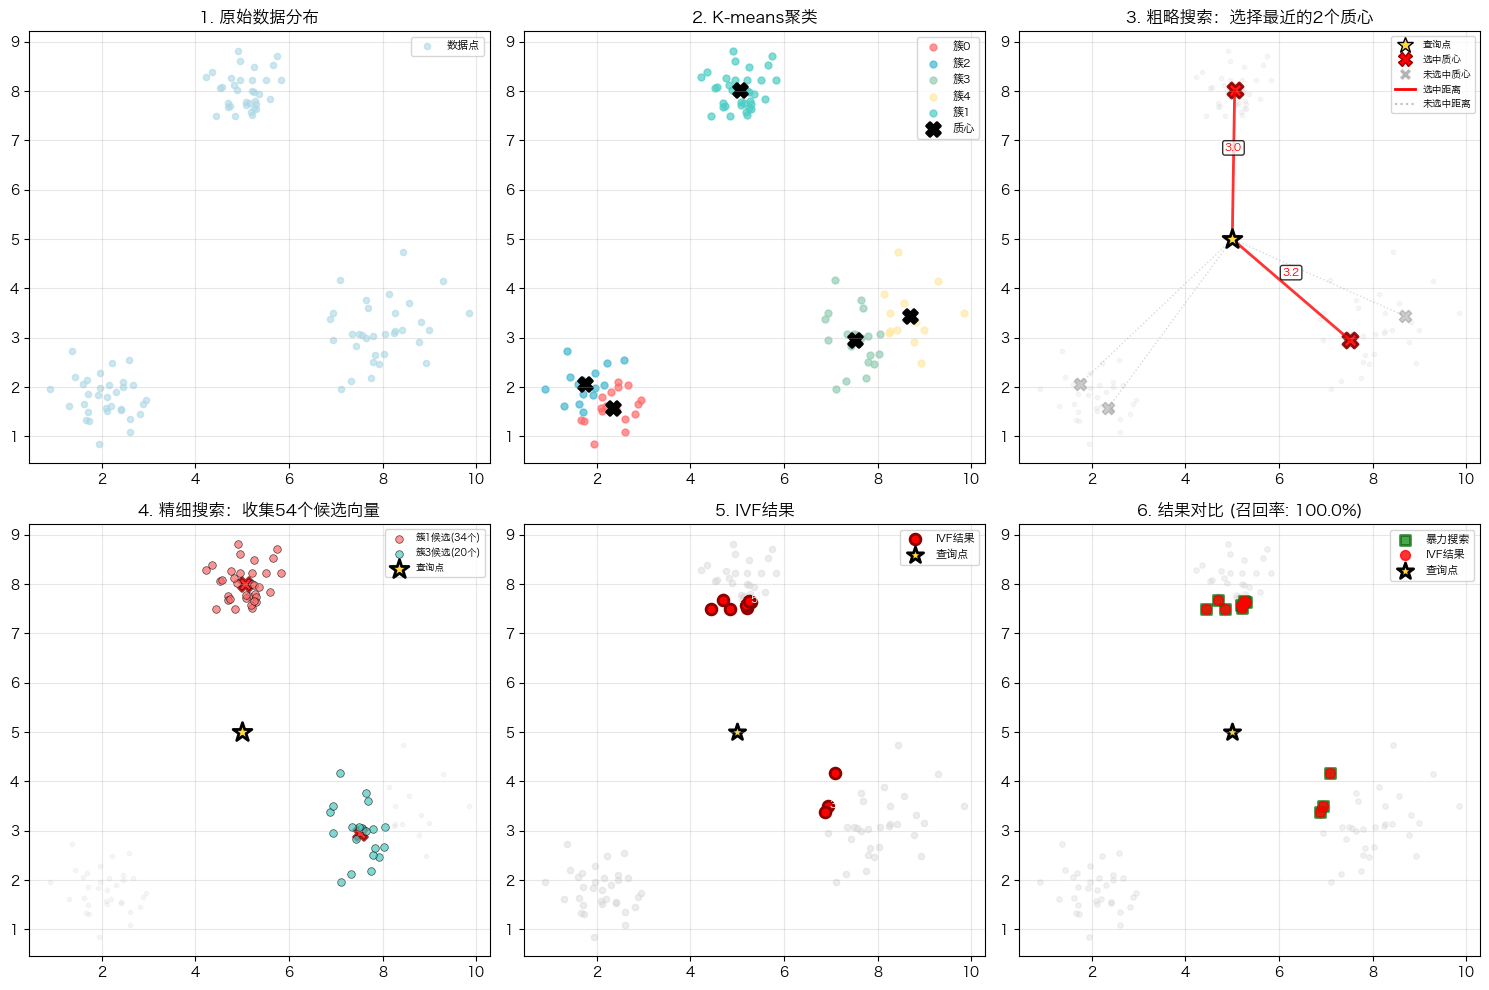


IVF算法统计:
数据量: 100 个向量
聚类数: 5 个簇
搜索簇: 2 个簇
候选向量: 54 个 (54.0%)
召回率: 100.0%


In [34]:
def visualize_ivf(ivf, data, query, ivf_results, bf_results):
    """IVF算法可视化"""
    plt.figure(figsize=(15, 10))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    
    # 计算查询相关信息
    distances_to_centroids = euclidean_distances([query], ivf.centroids)[0]
    nearest_cluster_indices = np.argsort(distances_to_centroids)[:ivf.n_probe]
    
    # 1. 原始数据分布
    plt.subplot(2, 3, 1)
    plt.scatter(data[:, 0], data[:, 1], c='lightblue', alpha=0.6, s=20, label='数据点')
    plt.title('1. 原始数据分布', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 2. K-means聚类
    plt.subplot(2, 3, 2)
    for cluster_id, indices in ivf.inverted_lists.items():
        cluster_data = data[indices]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=colors[cluster_id % len(colors)], alpha=0.7, s=25,
                   label=f'簇{cluster_id}')
    
    plt.scatter(ivf.centroids[:, 0], ivf.centroids[:, 1], 
               c='black', marker='X', s=100, linewidths=2, label='质心')
    plt.title('2. K-means聚类', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. 粗略搜索
    plt.subplot(2, 3, 3)
    
    # 背景：显示所有数据点（淡化）
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.2, s=10)
    
    # 显示所有质心，用不同透明度区分选中和未选中
    selected_centroids = set(nearest_cluster_indices)
    
    for i, centroid in enumerate(ivf.centroids):
        if i in selected_centroids:
            # 选中的质心：高亮显示
            plt.scatter(centroid[0], centroid[1], c='red', marker='X', 
                       s=120, linewidths=2, edgecolors='darkred', alpha=0.9)
            # 显示到查询点的距离线
            plt.plot([query[0], centroid[0]], [query[1], centroid[1]], 
                    'r-', alpha=0.8, linewidth=2)
            # 标注距离值
            dist = np.linalg.norm(query - centroid)
            mid_x, mid_y = (query[0] + centroid[0])/2, (query[1] + centroid[1])/2
            plt.annotate(f'{dist:.1f}', (mid_x, mid_y), 
                        xytext=(0, 10), textcoords='offset points',
                        fontsize=8, ha='center', color='red', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        else:
            # 未选中的质心：淡化显示
            plt.scatter(centroid[0], centroid[1], c='gray', marker='X', 
                       s=80, alpha=0.4, linewidths=1)
            # 显示到查询点的距离线（虚线）
            plt.plot([query[0], centroid[0]], [query[1], centroid[1]], 
                    'gray', linestyle=':', alpha=0.3, linewidth=1)
    
    # 查询点
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', linewidth=2, label='查询点', zorder=10)
    
    # 添加选择说明
    plt.title(f'3. 粗略搜索：选择最近的{ivf.n_probe}个质心', fontweight='bold')
    
    # 创建图例
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='#FFD93D', 
               markersize=12, markeredgecolor='black', label='查询点'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='red', 
               markersize=10, markeredgecolor='darkred', label='选中质心'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', 
               markersize=8, alpha=0.6, label='未选中质心'),
        Line2D([0], [0], color='red', linewidth=2, label='选中距离'),
        Line2D([0], [0], color='gray', linestyle=':', alpha=0.5, label='未选中距离')
    ]
    plt.legend(handles=legend_elements, fontsize=7, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 4. 精细搜索
    plt.subplot(2, 3, 4)
    
    # 背景：显示所有数据点（淡化）
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.2, s=10)
    
    # 显示选中的质心
    for cluster_idx in nearest_cluster_indices:
        plt.scatter(ivf.centroids[cluster_idx, 0], ivf.centroids[cluster_idx, 1], 
                   c='red', marker='X', s=100, linewidths=2, edgecolors='darkred', alpha=0.8)
    
    # 收集并按簇显示候选向量
    candidate_indices = []
    cluster_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for i, cluster_idx in enumerate(nearest_cluster_indices):
        cluster_candidates = ivf.inverted_lists[cluster_idx]
        candidate_indices.extend(cluster_candidates)
        
        # 用不同颜色显示不同簇的候选向量
        cluster_data = data[cluster_candidates]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=cluster_colors[i % len(cluster_colors)], alpha=0.7, s=30,
                   label=f'簇{cluster_idx}候选({len(cluster_candidates)}个)', 
                   edgecolors='black', linewidths=0.5)
    
    # 查询点
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', linewidth=2, label='查询点', zorder=10)
    
    plt.title(f'4. 精细搜索：收集{len(candidate_indices)}个候选向量', fontweight='bold')
    plt.legend(fontsize=7, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 5. IVF结果
    plt.subplot(2, 3, 5)
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.4, s=20)
    plt.scatter(data[ivf_results, 0], data[ivf_results, 1], 
               c='red', marker='o', s=60, edgecolors='darkred', 
               linewidth=2, label='IVF结果')
    
    for i, idx in enumerate(ivf_results[:5]):
        plt.annotate(f'{i+1}', (data[idx, 0], data[idx, 1]), 
                    xytext=(3, 3), textcoords='offset points', 
                    fontsize=8, color='white', fontweight='bold')
    
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=150, 
               edgecolors='black', linewidth=2, label='查询点')
    plt.title('5. IVF结果', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 6. 结果对比
    plt.subplot(2, 3, 6)
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.3, s=15)
    plt.scatter(data[bf_results, 0], data[bf_results, 1], 
               c='green', marker='s', s=60, edgecolors='darkgreen', 
               linewidth=2, label='暴力搜索', alpha=0.7)
    plt.scatter(data[ivf_results, 0], data[ivf_results, 1], 
               c='red', marker='o', s=50, alpha=0.8, label='IVF结果')
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=150, 
               edgecolors='black', linewidth=2, label='查询点')
    
    # 计算召回率
    intersection = set(ivf_results) & set(bf_results)
    recall = len(intersection) / len(bf_results)
    
    plt.title(f'6. 结果对比 (召回率: {recall:.1%})', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 简化的统计信息
    total_candidates = sum(len(ivf.inverted_lists[i]) for i in nearest_cluster_indices)
    search_ratio = total_candidates / len(data)
    
    print(f"\nIVF算法统计:")
    print(f"数据量: {len(data)} 个向量")
    print(f"聚类数: {ivf.n_clusters} 个簇")
    print(f"搜索簇: {ivf.n_probe} 个簇")
    print(f"候选向量: {total_candidates} 个 ({search_ratio:.1%})")
    print(f"召回率: {recall:.1%}")
    
    return recall


#用少量样本进行可视化
ivf_tiny, data_tiny, query_tiny, ivf_results_tiny, bf_results_tiny = demonstrate_ivf(data_size=100)
recall = visualize_ivf(ivf_tiny, data_tiny, query_tiny, ivf_results_tiny, bf_results_tiny)

In [17]:
def analyze_parameters():
    """分析n_probe参数对搜索效果的影响"""
    data = generate_sample_data(1000, 2)
    query = np.array([5.0, 5.0])
    
    n_probe_values = [1, 2, 3]
    results = []
    
    for n_probe in n_probe_values:
        ivf = SimpleIVF(n_clusters=5, n_probe=n_probe)
        ivf.data = data
        ivf.build_index(data)
        
        # IVF搜索
        start_time = time.time()
        ivf_indices, _ = ivf.search(query, k=5, data=data)
        ivf_time = time.time() - start_time
        
        # 暴力搜索作为基准
        bf_indices, _ = ivf.brute_force_search(query, k=5, data=data)
        
        # 计算召回率
        intersection = set(ivf_indices) & set(bf_indices)
        recall = len(intersection) / len(bf_indices)
        
        results.append({
            'n_probe': n_probe,
            'recall': recall,
            'time': ivf_time,
            'candidates_searched': sum(len(ivf.inverted_lists[i]) 
                                    for i in range(n_probe))
        })
    
    # 显示结果
    print("\n" + "="*50)
    print("n_probe参数影响分析")
    print("="*50)
    
    for result in results:
        print(f"n_probe={result['n_probe']}: "
              f"召回率={result['recall']:.1%}, "
              f"耗时={result['time']:.6f}秒, "
              f"搜索向量数={result['candidates_searched']}")
    
    return results

# 运行参数分析
parameter_results = analyze_parameters()

开始训练IVF索引...
训练完成，得到5个簇
倒排索引构建完成「展示前5个簇」:
  簇4: 333个向量
  簇1: 100个向量
  簇2: 110个向量
  簇3: 123个向量
  簇0: 334个向量
开始训练IVF索引...
训练完成，得到5个簇
倒排索引构建完成「展示前5个簇」:
  簇0: 170个向量
  簇1: 163个向量
  簇3: 333个向量
  簇4: 150个向量
  簇2: 184个向量
开始训练IVF索引...
训练完成，得到5个簇
倒排索引构建完成「展示前5个簇」:
  簇0: 333个向量
  簇2: 153个向量
  簇1: 180个向量
  簇4: 191个向量
  簇3: 143个向量

n_probe参数影响分析
n_probe=1: 召回率=80.0%, 耗时=0.001708秒, 搜索向量数=334
n_probe=2: 召回率=80.0%, 耗时=0.000682秒, 搜索向量数=333
n_probe=3: 召回率=100.0%, 耗时=0.000797秒, 搜索向量数=666


**⚖️ 第六步：参数影响分析**

让我们分析n_probe参数对搜索效果的影响：

从结论我们可以发现​速度与精度的基本权衡关系​​
1.从 n_probe=2到 n_probe=3的变化，完美体现了IVF算法中​​速度与精度的经典权衡​​。
- 当 n_probe从2增加到3时，搜索的簇数量增加，因此需要计算的向量数量几乎翻倍（从333增加到666）。这导致搜索范围扩大，从而​​召回率从80%提升到了100%​​，但代价是​​耗时也有所增加​​（从0.000682秒增加到0.000797秒）。
这说明，​​增大 n_probe通常能以牺牲速度为代价来提升召回率​​。

​2.​发现异常点：n_probe=1的性能反常​​
这是一个非常关键的发现，这理论上，n_probe=1（只搜索1个最近的簇）应该是最快的，但结果却显示它​​最慢（0.001708秒）​​。
- 在 n_probe=1时，由于编程语言（如Python）的解释器开销、缓存未命中或其他偶然因素所致，你多尝试几次会发现n_probe=1的时间会有波动，这就是编译器本身编译或者缓存导致
​
最后，可以总结出以下核心要点：

- 基本规律成立​​：n_probe增大，搜索范围扩大，召回率提高，但耗时增加。
- ​​实践出真知​​：理论规律需要在实际测试中验证。实验中可能会出现像 n_probe=1这样的性能异常点，这正体现了参数调优和基准测试的重要性。
- ​​没有“最好”的参数，只有“最合适”的参数​​：最终的参数选择取决于应用场景对​​速度​​和​​精度​​的具体要求。